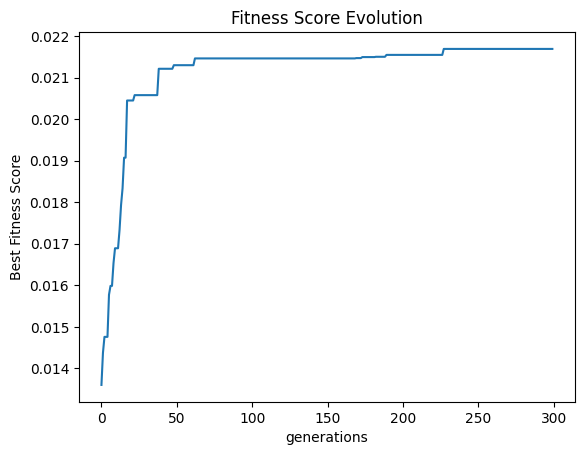

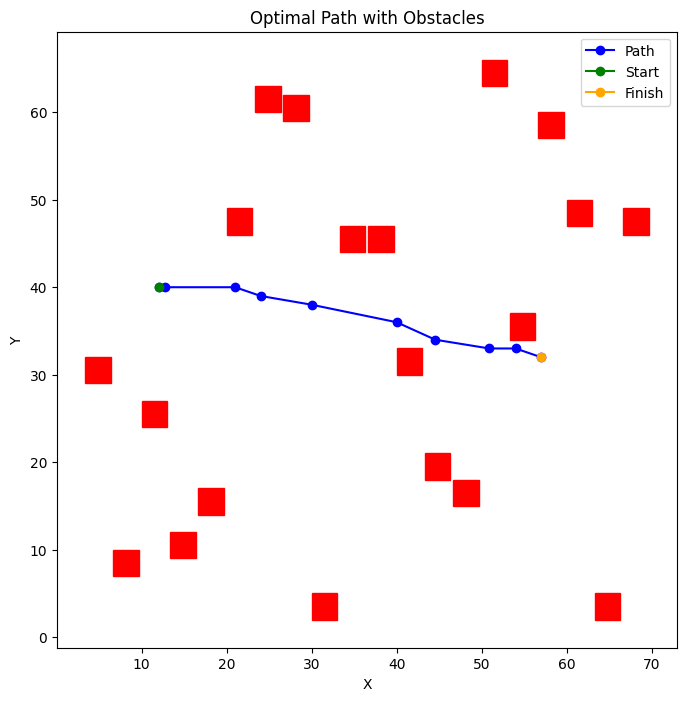

In [ ]:
import random
import matplotlib.pyplot as plt

class Chromosome:
    def __init__(self, path):
        self.path = path
        self.fitness = 0

    @classmethod
    def random_chromosome(chromo, points, start, finish):
        start_x, start_y = start
        finish_x, finish_y = finish
        x_interval = (finish_x - start_x) / (points + 1)

        if start_y == finish_y:
            path = [(start_x + (i + 1) * x_interval, start_y) for i in range(points)]
        else:
            path = [(start_x + (i + 1) * x_interval, random.randint(min(start_y, finish_y), max(start_y, finish_y))) for i in range(points)]
        return chromo(path)

    def calculate_fitness(self, obstacles):
        total_distance = self.calculate_total_distance()
        num_collisions = self.count_collisions(obstacles)
        self.fitness = 1 / (total_distance + 1e-10 * num_collisions) #either total_distance small or plot too big

    def calculate_total_distance(self):
        total_distance = 0
        for i in range(len(self.path) - 1):
            total_distance += self.get_distance(self.path[i], self.path[i + 1])
        return total_distance

    def get_distance(self, point1, point2):
        return ((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2) ** 0.5

    def count_collisions(self, obstacles):
        return sum(self.collides_with_obstacle(obstacle) for obstacle in obstacles)

    def collides_with_obstacle(self, obstacle):
        obstacle_x, obstacle_y, obstacle_size = obstacle
        return any(
            obstacle_x <= point[0] <= obstacle_x + obstacle_size and
            obstacle_y <= point[1] <= obstacle_y + obstacle_size
            for point in self.path
        )

class Graphing:
    def __init__(self, generations):
        self.generations = generations
        self.best_fitness_scores = []

    def plot_fitness_scores(self):
        plt.plot(range(self.generations), self.best_fitness_scores)
        plt.xlabel('generations')
        plt.ylabel('Best Fitness Score')
        plt.title('Fitness Score Evolution')
        plt.show()

    def plot_path_with_obstacles(self, path, obstacles, start, finish):
        plt.figure(figsize=(8, 8))
        plt.plot(*zip(*path), marker='o', color='blue', label='Path')

        for obstacle in obstacles:
            obstacle_pos = (obstacle[0], obstacle[1])
            obstacle_size = obstacle[2]

            obstacle_rect = plt.Rectangle(
                obstacle_pos,
                obstacle_size,
                obstacle_size,
                color='red'
            )
            plt.gca().add_patch(obstacle_rect)

        plt.plot(*start, marker='o', color='green', label='Start')
        plt.plot(*finish, marker='o', color='orange', label='Finish')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Optimal Path with Obstacles')
        plt.legend()
        plt.show()

class GeneticAlgorithm:
    def __init__(self, points, population_size, generations, mutation_rate):
        self.points = points
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate

    def generate_initial_population(self):
        plot_size = 70
        start_point = (0, random.randint(0, plot_size))
        finish_point = (plot_size, random.randint(0, plot_size))
        obstacle_size = 3
        num_obstacles = self.points * 2
        obstacle_spacing = plot_size / (num_obstacles + 1)
        obstacles = []
        for i in range(num_obstacles):
            x = (i + 1) * obstacle_spacing
            y = random.randint(0, plot_size - obstacle_size)
            obstacle = (x, y, obstacle_size)
            obstacles.append(obstacle)
        population = []
        for _ in range(self.population_size):
            chromosome = Chromosome.random_chromosome(self.points, start_point, finish_point)
            population.append(chromosome)
        return population, obstacles

    def select_parents(self, population):
        parent1 = random.choice(population)
        parent2 = random.choice(population)
        return parent1 if parent1.fitness > parent2.fitness else parent2

    def crossover(self, parent1, parent2):
        crossover_point = random.randint(0, self.points - 1)
        child_path = parent1.path[:crossover_point] + parent2.path[crossover_point:]
        return Chromosome(child_path)

    def mutate(self, child):
        for i in range(self.points):
            if random.random() < self.mutation_rate:
                child.path[i] = (random.randint(0, 70), random.randint(0, 70))

    def next_generation(self):
        population, obstacle_list = self.generate_initial_population()
        graphing = Graphing(self.generations)

        for generations in range(self.generations):
            for individual in population:
                individual.calculate_fitness(obstacle_list)
            best_individual = max(population, key=lambda ind: ind.fitness)
            graphing.best_fitness_scores.append(best_individual.fitness)
            new_population = [best_individual]
            while len(new_population) < self.population_size:
                parent1 = self.select_parents(population)
                parent2 = self.select_parents(population)
                child = self.crossover(parent1, parent2)
                self.mutate(child)
                new_population.append(child)

            population = new_population
            best_individual = max(population, key=lambda ind: ind.fitness)

        path = best_individual.path
        obstacles = obstacle_list
        graphing.plot_fitness_scores()
        start_point = population[0].path[0]
        finish_point = population[0].path[-1]
        graphing.plot_path_with_obstacles(path, obstacles, start_point, finish_point)

        return best_individual

points = 10
population_size = 100
generations = 300
mutation_rate = 0.01

genetic_algorithm = GeneticAlgorithm(points, population_size, generations, mutation_rate)
best_individual = genetic_algorithm.next_generation()